In [14]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [15]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [7]:
tokenizer = Tokenizer()

# All data in one string:
data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

# Split into sentences:
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # Add 1 for OOV.

print(tokenizer.word_index)
print(total_words)
print(corpus)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

**Pro tip:** If you pass line instead of [line], you get a sequence character by character instead of word by word. tokenizer.texts_to_sequences([line]) gives [[34, 417, 877, 166, 213, 517]]. Since this is nested, we use tokenizer.texts_to_sequences([line])[0].



**Note:** We use pre-padding so that the last element in the sequence after padding is the label for the n-gram. See 'n-grams.png' in the course folder.

In [18]:
input_sequences = []
for line in corpus: # Go through every line in corpus
	token_list = tokenizer.texts_to_sequences([line])[0] # See explanation above
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)
print(input_sequences)
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) # One hot encoding
print(token_list)
print(n_gram_sequence)

[[4, 2], [4, 2, 66], [4, 2, 66, 8], [4, 2, 66, 8, 67], [4, 2, 66, 8, 67, 68], [4, 2, 66, 8, 67, 68, 69], [4, 2, 66, 8, 67, 68, 69, 70], [71, 40], [71, 40, 20], [71, 40, 20, 21], [71, 40, 20, 21, 72], [71, 40, 20, 21, 72, 3], [71, 40, 20, 21, 72, 3, 73], [16, 74], [16, 74, 75], [16, 74, 75, 1], [16, 74, 75, 1, 76], [16, 74, 75, 1, 76, 33], [16, 74, 75, 1, 76, 33, 3], [16, 74, 75, 1, 76, 33, 3, 77], [16, 74, 75, 1, 76, 33, 3, 77, 22], [41, 33], [41, 33, 3], [41, 33, 3, 78], [41, 33, 3, 78, 1], [41, 33, 3, 78, 1, 79], [41, 33, 3, 78, 1, 79, 80], [41, 33, 3, 78, 1, 79, 80, 8], [41, 33, 3, 78, 1, 79, 80, 8, 81], [21, 82], [21, 82, 3], [21, 82, 3, 83], [21, 82, 3, 83, 84], [21, 82, 3, 83, 84, 7], [21, 82, 3, 83, 84, 7, 42], [21, 82, 3, 83, 84, 7, 42, 1], [21, 82, 3, 83, 84, 7, 42, 1, 43], [85, 86], [85, 86, 87], [85, 86, 87, 33], [85, 86, 87, 33, 44], [85, 86, 87, 33, 44, 88], [85, 86, 87, 33, 44, 88, 13], [85, 86, 87, 33, 44, 88, 13, 2], [85, 86, 87, 33, 44, 88, 13, 2, 45], [1, 89], [1, 89,

In [20]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [21]:
print(xs[6])

[ 0  0  0  4  2 66  8 67 68 69]


**Note:** ys will be of length num_words. The corresponding word in ys (next word in the sentence) will be set to 1 in the one hot vector.

In [22]:
print(ys[6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

**Pro tip:** The (max_sequence_len - 1) comes from the fact if we have a training set "I go to the park to play" and we want to predict "play," that word, "play" cannot be in the training set, so all of the training sentences need to be reduced by 1 to account for us predicting the next word.

**Note:** We are using a 64 dimensional embedding for each word in the sentences.

**Note:** We are using a lot of epochs because we don't have a lot of data. We can see that accuracy improves over time.

In [34]:
  model = Sequential()
  model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
  model.add(Bidirectional(LSTM(20)))
  model.add(Dense(total_words, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(xs, ys, epochs=500, verbose=1)


Epoch 1/500
453/453 [==============================] - 1s 2ms/sample - loss: 5.5702 - accuracy: 0.0132
Epoch 2/500
453/453 [==============================] - 0s 394us/sample - loss: 5.5503 - accuracy: 0.0596
Epoch 3/500
453/453 [==============================] - 0s 391us/sample - loss: 5.5130 - accuracy: 0.0751
Epoch 4/500
453/453 [==============================] - 0s 398us/sample - loss: 5.3877 - accuracy: 0.0795
Epoch 5/500
453/453 [==============================] - 0s 424us/sample - loss: 5.1715 - accuracy: 0.0596
Epoch 6/500
453/453 [==============================] - 0s 400us/sample - loss: 5.0666 - accuracy: 0.0486
Epoch 7/500
453/453 [==============================] - 0s 390us/sample - loss: 5.0244 - accuracy: 0.0486
Epoch 8/500
453/453 [==============================] - 0s 388us/sample - loss: 4.9885 - accuracy: 0.0508
Epoch 9/500
453/453 [==============================] - 0s 389us/sample - loss: 4.9560 - accuracy: 0.0552
Epoch 10/500
453/453 [==============================] - 0

453/453 [==============================] - 0s 405us/sample - loss: 2.4325 - accuracy: 0.5166
Epoch 79/500
453/453 [==============================] - 0s 390us/sample - loss: 2.4187 - accuracy: 0.5143
Epoch 80/500
453/453 [==============================] - 0s 398us/sample - loss: 2.3888 - accuracy: 0.5232
Epoch 81/500
453/453 [==============================] - 0s 396us/sample - loss: 2.3608 - accuracy: 0.5232
Epoch 82/500
453/453 [==============================] - 0s 404us/sample - loss: 2.3996 - accuracy: 0.5099
Epoch 83/500
453/453 [==============================] - 0s 397us/sample - loss: 2.3535 - accuracy: 0.5276
Epoch 84/500
453/453 [==============================] - 0s 400us/sample - loss: 2.3291 - accuracy: 0.5320
Epoch 85/500
453/453 [==============================] - 0s 381us/sample - loss: 2.3076 - accuracy: 0.5541
Epoch 86/500
453/453 [==============================] - 0s 393us/sample - loss: 2.2807 - accuracy: 0.5607
Epoch 87/500
453/453 [==============================] - 0s 

453/453 [==============================] - 0s 447us/sample - loss: 1.2173 - accuracy: 0.8168
Epoch 155/500
453/453 [==============================] - 0s 398us/sample - loss: 1.2063 - accuracy: 0.8168
Epoch 156/500
453/453 [==============================] - 0s 387us/sample - loss: 1.2023 - accuracy: 0.8234
Epoch 157/500
453/453 [==============================] - 0s 399us/sample - loss: 1.1893 - accuracy: 0.8102
Epoch 158/500
453/453 [==============================] - 0s 389us/sample - loss: 1.1785 - accuracy: 0.8146
Epoch 159/500
453/453 [==============================] - 0s 401us/sample - loss: 1.1665 - accuracy: 0.8234
Epoch 160/500
453/453 [==============================] - 0s 388us/sample - loss: 1.1563 - accuracy: 0.8256
Epoch 161/500
453/453 [==============================] - 0s 389us/sample - loss: 1.1475 - accuracy: 0.8234
Epoch 162/500
453/453 [==============================] - 0s 389us/sample - loss: 1.1401 - accuracy: 0.8278
Epoch 163/500
453/453 [============================

453/453 [==============================] - 0s 411us/sample - loss: 0.6450 - accuracy: 0.9139
Epoch 231/500
453/453 [==============================] - 0s 394us/sample - loss: 0.6337 - accuracy: 0.9161
Epoch 232/500
453/453 [==============================] - 0s 390us/sample - loss: 0.6275 - accuracy: 0.9205
Epoch 233/500
453/453 [==============================] - 0s 398us/sample - loss: 0.6345 - accuracy: 0.9161
Epoch 234/500
453/453 [==============================] - 0s 396us/sample - loss: 0.6380 - accuracy: 0.9117
Epoch 235/500
453/453 [==============================] - 0s 398us/sample - loss: 0.6711 - accuracy: 0.8985
Epoch 236/500
453/453 [==============================] - 0s 400us/sample - loss: 0.6833 - accuracy: 0.8962
Epoch 237/500
453/453 [==============================] - 0s 391us/sample - loss: 0.6860 - accuracy: 0.8874
Epoch 238/500
453/453 [==============================] - 0s 383us/sample - loss: 0.6567 - accuracy: 0.9095
Epoch 239/500
453/453 [============================

453/453 [==============================] - 0s 397us/sample - loss: 0.3703 - accuracy: 0.9382
Epoch 307/500
453/453 [==============================] - 0s 392us/sample - loss: 0.3686 - accuracy: 0.9360
Epoch 308/500
453/453 [==============================] - 0s 395us/sample - loss: 0.3670 - accuracy: 0.9338
Epoch 309/500
453/453 [==============================] - 0s 391us/sample - loss: 0.3621 - accuracy: 0.9360
Epoch 310/500
453/453 [==============================] - 0s 394us/sample - loss: 0.3594 - accuracy: 0.9360
Epoch 311/500
453/453 [==============================] - 0s 387us/sample - loss: 0.3588 - accuracy: 0.9360
Epoch 312/500
453/453 [==============================] - 0s 386us/sample - loss: 0.3605 - accuracy: 0.9338
Epoch 313/500
453/453 [==============================] - 0s 388us/sample - loss: 0.3577 - accuracy: 0.9272
Epoch 314/500
453/453 [==============================] - 0s 387us/sample - loss: 0.3522 - accuracy: 0.9360
Epoch 315/500
453/453 [============================

453/453 [==============================] - 0s 396us/sample - loss: 0.2437 - accuracy: 0.9470
Epoch 383/500
453/453 [==============================] - 0s 388us/sample - loss: 0.2417 - accuracy: 0.9448
Epoch 384/500
453/453 [==============================] - 0s 397us/sample - loss: 0.2400 - accuracy: 0.9448
Epoch 385/500
453/453 [==============================] - 0s 385us/sample - loss: 0.2375 - accuracy: 0.9448
Epoch 386/500
453/453 [==============================] - 0s 391us/sample - loss: 0.2370 - accuracy: 0.9492
Epoch 387/500
453/453 [==============================] - 0s 397us/sample - loss: 0.2356 - accuracy: 0.9470
Epoch 388/500
453/453 [==============================] - 0s 394us/sample - loss: 0.2359 - accuracy: 0.9492
Epoch 389/500
453/453 [==============================] - 0s 393us/sample - loss: 0.2330 - accuracy: 0.9470
Epoch 390/500
453/453 [==============================] - 0s 418us/sample - loss: 0.2326 - accuracy: 0.9448
Epoch 391/500
453/453 [============================

453/453 [==============================] - 0s 401us/sample - loss: 0.1740 - accuracy: 0.9492
Epoch 459/500
453/453 [==============================] - 0s 387us/sample - loss: 0.1746 - accuracy: 0.9514
Epoch 460/500
453/453 [==============================] - 0s 389us/sample - loss: 0.1748 - accuracy: 0.9426
Epoch 461/500
453/453 [==============================] - 0s 386us/sample - loss: 0.1729 - accuracy: 0.9470
Epoch 462/500
453/453 [==============================] - 0s 388us/sample - loss: 0.1719 - accuracy: 0.9492
Epoch 463/500
453/453 [==============================] - 0s 386us/sample - loss: 0.1709 - accuracy: 0.9492
Epoch 464/500
453/453 [==============================] - 0s 396us/sample - loss: 0.1716 - accuracy: 0.9492
Epoch 465/500
453/453 [==============================] - 0s 397us/sample - loss: 0.1704 - accuracy: 0.9492
Epoch 466/500
453/453 [==============================] - 0s 394us/sample - loss: 0.1699 - accuracy: 0.9492
Epoch 467/500
453/453 [============================

In [35]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

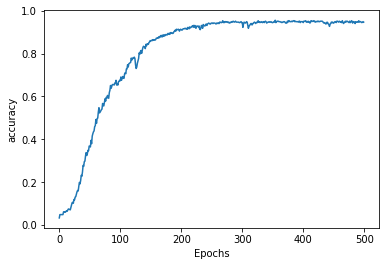

In [29]:
plot_graphs(history, 'accuracy')


**Note:** Each next word is based on the highest probability. Since our corpus is small, the quality of predictions goes down as the sequence lengthens. For example, we have repeated words sometimes. This is because the probability that each word matches an existing phrase goes down as the number of words you create increases.

In [36]:
seed_text = "Laurence went to dublin"
next_words = 100 # Ask to predict the next n words
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Laurence went to dublin punch and wine for give give ground to call painted painted free invitation invitation replied weeks at wall invitation suppose suppose suppose me me me me as me ground ground me a call rose rose rose saw me ground me ground call weeks end a call rose rose saw me me a call call call call entangled rose gave me a call call call call entangled rose entangled rose gave a call call call call suppose gave me me me a call call call mchugh entangled rose creature rose glisten glisten replied me a call call call call entangled rose
